In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    RandomizedSearchCV,
)

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
631471,1160857864061235200,eu chego na escola querendo ir embora 😴,-0.080780,-1
137123,1559870134323478531,o pai tá voltando! 💪✨🤍,0.908308,1
654222,1160893450524471297,cólica do caralho 😤,-0.211009,-1
454721,1160598914845872135,só doideira com os amigos ontem kkk 😝,0.425403,1
339376,1559978727680901120,to atolada de coisa pra fazer e cheia de paran...,-0.093377,-1
588276,1160752441882796032,recomendo a 🔝 gata gostou siga e confira muito...,0.478548,1
205560,1559900347975536643,já tô bruto pela manhã tmnc 😡😡😡,-0.519841,-1
227706,1559908870688067584,esqueee 🔥🔥🔥,0.419355,1
789376,1161111254922121226,amanhã tenho as melhores aulas 😍,0.677937,1
388754,1160081685091966976,eu quero estágio 😭,-0.093377,-1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

108        lhe
56     estiver
160       seus
166     também
204       você
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: rayza fez um escândalo colossal por não ter conhecido ele ainda, menina 😂

Tweet Limpo   : rayza fez escândalo colossal ter conhecido ainda menina

Tweet Stemed  : rayz fez escândal coloss ter conhec aind menin


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
624557,1160846851819659269,aaa olha quem falaaa!!! 😍,0.677937,1,aaa olh falaa
422364,1160356546985046016,a maria clara é tão linda 😭,-0.093377,-1,mar cl tão lind
386504,1160065219550482434,"não entendo esse grt , nmrl 😂",0.220968,0,ent grt nmrl
413774,1160337273432485889,fofinha eu tiamoo 💕,0.632917,1,fof tiamo
683440,1160930151770808326,que tristeza 😭 eu não tô preparada,-0.093377,-1,trist tô prepar


# Engenharia de Atributos: Probabilidade das Ocorrencias

Este modelo é uma variação da Soma das Frequencias.

Vamos transformar o texto numa representação vetorial utilizando a probabilidade da ocorrencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

In [11]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [12]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

Chaves: 58366


In [13]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

Chaves: 27524


In [14]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

Chaves: 32001


### Visualização dos Dicionários

In [15]:
dicionarios = pd.DataFrame(
    [
        pd.Series(dicionario_positivo, name="positivo"),
        pd.Series(dicionario_neutro, name="neutro"),
        pd.Series(dicionario_negativo, name="negativo"),
    ]
).T

In [16]:
dicionarios.sample(10)

,positivo,neutro,negativo
epilog,1.0,NaN,NaN
alborot,NaN,1.0,NaN
benvingud,1.0,NaN,NaN
saucy,NaN,1.0,1.0
derech,2.0,1.0,NaN
temt,1.0,NaN,NaN
desesperoo,NaN,1.0,NaN
particul,76.0,12.0,23.0
compareç,3.0,NaN,NaN
inviol,5.0,NaN,NaN


## Gerar dicionário das probabilidades

A partir do dicionário de frequencias, vamos gerar o dicionário de probabilidades.

Basicamente, vamos dividir a frequencia que uma palavra aparece em determinado rótulo pela quantidade de palavras naquele rótulo.

Porém, para evitar que tenhamos probabilidade zero, aplicaremos uma Suavização Laplaciana.

In [17]:
def gerar_probabilidades(serie, total_ocorrencias_dimensao):
    serie = serie.fillna(0)
    return serie / total_ocorrencias_dimensao

In [18]:
dicionarios["positivo"] = gerar_probabilidades(
    dicionarios["positivo"], dicionarios["positivo"].sum()
)

In [19]:
dicionarios["negativo"] = gerar_probabilidades(
    dicionarios["negativo"], dicionarios["negativo"].sum()
)

In [20]:
dicionarios["neutro"] = gerar_probabilidades(
    dicionarios["neutro"], dicionarios["neutro"].sum()
)

### Visualização do Dicionário

In [21]:
dicionarios.sample(10)

,positivo,neutro,negativo
animevers,0.000000e+00,0.000002,0.000000e+00
thaisguimaresg,4.630328e-07,0.000000,0.000000e+00
maconvert,0.000000e+00,0.000000,9.795135e-07
conf,2.958780e-04,0.000394,1.057875e-04
choppin,4.630328e-07,0.000000,0.000000e+00
pocotó,0.000000e+00,0.000002,0.000000e+00
marys,0.000000e+00,0.000000,9.795135e-07
zaffar,9.260657e-07,0.000004,0.000000e+00
kralhoo,4.630328e-07,0.000000,9.795135e-07
fatimaecel,4.630328e-07,0.000000,0.000000e+00


In [22]:
dicionarios["positivo"].sum()

0.9999999999999999

## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [23]:
def gerar_feature_vector(string, df):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([df["positivo"].get(word, 0) for word in tokens])
    feature_neutra = sum([df["neutro"].get(word, 0) for word in tokens])
    feature_negativa = sum([df["negativo"].get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [24]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(tweet, dicionarios)

print("Tweet: {}".format(tweet))
feature_vector

Tweet: lev famíl contig col trê coraçã dad person banh our


positiva    0.005386
neutra      0.004209
negativa    0.005186
dtype: float64

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [25]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(x, dicionarios)
)
features_train["label"] = X_train["label"]

In [26]:
features_train.sample(5)

,positiva,neutra,negativa,label
20439,0.014764,0.017816,0.020618,-1
270430,0.004758,0.005393,0.005660,0
591743,0.015936,0.010799,0.012465,1
624393,0.039531,0.019218,0.021527,1
214271,0.008690,0.006229,0.006686,1


In [27]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

,positiva,neutra,negativa
45088,0.008034,0.007252,0.005528
113244,0.000340,0.000709,0.000474
241138,0.010644,0.013873,0.015995
29435,0.005918,0.007229,0.007707
660494,0.000342,0.000486,0.000733


In [28]:
y_features_train = features_train["label"]
y_features_train.sample(5)

144697   -1
378786    1
33024    -1
317237   -1
735430    0
Name: label, dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [29]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(x, dicionarios)
)
features_test["label"] = X_test["label"]

In [30]:
features_test.sample(5)

,positiva,neutra,negativa,label
661612,0.001102,0.000894,0.000686,-1
103183,0.016088,0.008828,0.009295,1
591315,0.005805,0.007696,0.007887,1
222880,0.065262,0.060457,0.071252,1
233279,0.010881,0.014328,0.027107,-1


In [31]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

,positiva,neutra,negativa
704918,0.010471,0.001989,0.003098
309932,0.022782,0.023367,0.024716
178224,0.004804,0.005669,0.010916
724791,0.010257,0.001728,0.002789
723967,0.025600,0.020389,0.021806


In [32]:
y_features_test = features_test["label"]
y_features_test.sample(5)

159743    0
607950   -1
816852    1
748699    0
896155    1
Name: label, dtype: int64

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [33]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler()

In [34]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

,positiva,neutra,negativa
162894,4.224219,1.916034,1.810351
507564,-0.346521,-0.164607,0.041498
280962,-0.928435,-0.912174,-0.902928
326599,-0.703885,-0.596925,-0.595121
41724,-0.824647,-0.731893,-0.590687


In [35]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

,positiva,neutra,negativa
133273,0.175618,0.389779,0.550705
202606,-0.910323,-0.864443,-0.856702
9992,-0.639701,-0.492917,-0.501071
192690,-0.625336,-0.424546,-0.326635
181342,0.319416,-0.131712,-0.069778


# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [36]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 8.41%


In [37]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 14.25%


In [38]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 24.57%


In [39]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 24.57%


## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [40]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [41]:
params = {
    "C": np.linspace(0.5, 2, 100),
    "tol": np.linspace(1e-5, 1e-3, 100),
}

clf = RandomizedSearchCV(log, params, scoring="f1_macro", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 35.62%


In [42]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [43]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 24.57%
Score Modelo   : 35.62%
Diferença      : 11.05%


### Performance no Conjunto de Treino

In [44]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 35.62%


### Curva de Aprendizado

In [45]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

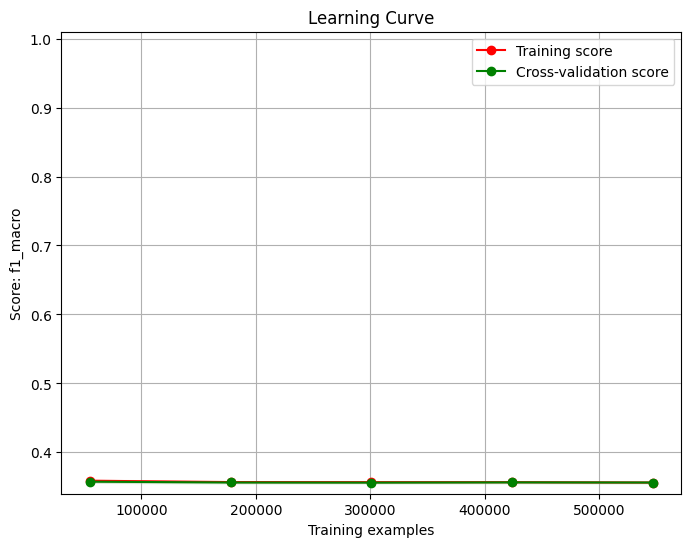

In [46]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Histogram-Based Gradient Boosting

Referências:
- [https://en.wikipedia.org/wiki/Gradient_boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

In [47]:
hgb = HistGradientBoostingClassifier(
    tol=0.00024,
    min_samples_leaf=5,
    learning_rate=0.74,
    random_state=42,
)

In [48]:
s1 = time()
scores = cross_val_score(
    hgb, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
hgb_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(hgb_score * 100))

Elapsed Time:  6 seconds
F-Score: 42.60%


In [49]:
hgb.fit(X_features_train_scaled, y_features_train)

HistGradientBoostingClassifier(learning_rate=0.74, min_samples_leaf=5,
                               random_state=42, tol=0.00024)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [50]:
# hgb = HistGradientBoostingClassifier(random_state = 42)
# params = {
#    "learning_rate": np.linspace(0.01, 1, 20),
#    "tol": np.linspace(1e-5, 1e-3, 100),
#    'min_samples_leaf': [x for x in range(1,11)],
# }
#
# clf = RandomizedSearchCV(hgb, params, scoring='f1_macro', random_state=42)
# clf.fit(X_features_train_scaled, y_features_train)
#
# print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [51]:
# clf.best_params_
print(
    {
        "tol": 0.00023999999999999998,
        "min_samples_leaf": 5,
        "learning_rate": 0.7394736842105263,
    }
)

{'tol': 0.00023999999999999998, 'min_samples_leaf': 5, 'learning_rate': 0.7394736842105263}


In [52]:
# hgb = clf.best_estimator_

#### Comparação com Métrica base

In [53]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(hgb_score * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - hgb_score) * 100))

Score Baseline : 24.57%
Score Modelo   : 42.60%
Diferença      : 18.03%


### Performance no Conjunto de Treino

In [54]:
y_pred = hgb.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 43.03%


### Curva de Aprendizado

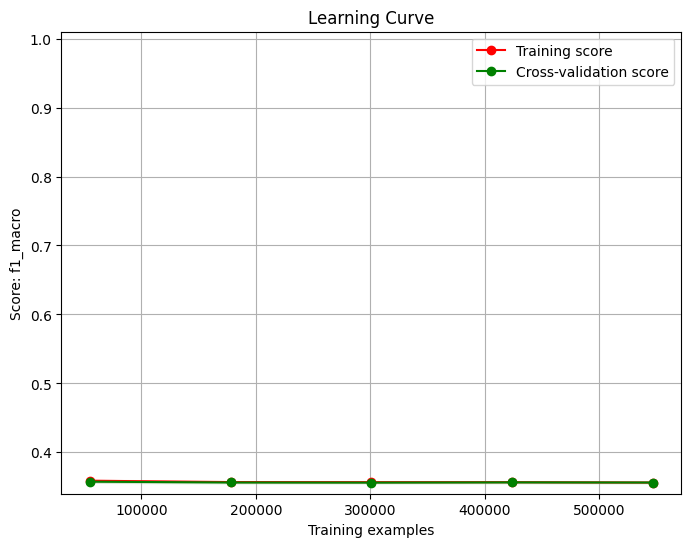

In [55]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Validação em conjunto de Teste

In [56]:
y_pred = hgb.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 41.81%


### Preditos Positivos

In [57]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [58]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['bom diaaa 😴', 'aaa que saudade 😔',
       'uma agonia: camisa social com prata por cima. 😖', '😭 então',
       'e esse corno aqui que comeu a maçãzinha até virar um coração 😭',
       'é vida né sofi 😓', 'q gatinho 😠',
       'meus gatos tudo gritando por mim 😔',
       'ja fooi e ainda é a minha notificação preferida kkk 😡',
       'mds 😭😭😭 lua eu te adoro, sério, que ódio 💔🔨'], dtype=object)

#### Falso Positivo -> Neutro

In [59]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['se eu fizer isso ele não aparece mas minha casa ia virar o projeto x. 😂',
       'dia - por que você gosta do sebastian? que ele é lindo isso geral já sabe 😂 mas o meu gostar dele vai além dis…',
       'mentira man ninguém ali trai são todos homens de família 👀',
       'bigodes, hoje joga o 🔥 vamos ter episódio, logo após o final do encontro, pelas h ⚠️ qual o vosso prognóstico para o resultado de hoje à noite?',
       'ah pois tenho, liga-me quando puderes 😂 é mais fácil',
       'eu gosta vei pra comer esse cuzinho gostoso 🔥',
       'wilson witzel disse, se vc estiver com um fuzil nas mãos a única certeza é que vamos te matar 😂',
       '👀atentos 👀 📷 nova foto do harry, durante as gravações na escócia ( . . )',
       'amigo do meu amigo que podia ser meu namorado, muda p jf 😅',
       'parabéns pra vc eu só vim pra comeeer e o presente q é bommm esqueci de trazer 😅 kakakkakaka'],
      dtype=object)

#### Verdadeiro Positivo

In [60]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['bom dia 💘', 'lindíssima 😊😊', 'kkk uai, só marcar 😁',
       'que se passa mary? eu não te ignoro meu amor. sorry se alguma vez te fiz isso 🥺💜',
       '🤣🤣🤣😂🤣 pode trocando não gostei 😌', 'bom dia! 😉',
       'se eu fosse só já não estaria mais aqui…. 💖',
       'autocuidado é tudo 💜',
       'chupa santos! freguesia de vcs continua hahaha grande dia 👍',
       'tenho high kin na luz e na marcy 😁😁😁 (alguém me ajud'],
      dtype=object)

### Preditos Negativos

In [61]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [62]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['as vezes eu esqueço de entrar no instagram e as pessoas acham q e por querer 😏',
       'vou ver a moon hj 💗💗💗',
       'de vacilação e mancada eu quero distância 👋', 'defeito mds 😍',
       'odeio pessoas de exatas 👍', 'to apaixonadaa😍',
       'queria ser menino heinn 😍 vc é o dono da perfeição cara, af 💗💗💗',
       'team camo ❤', 'amanhã vou levar bolo e torta p comer na escola 😋',
       'oia q legal eu voltando da escola e o cara me assedia 😍😍😍'],
      dtype=object)

#### Falso Negativo -> Neutro

In [63]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['queria morar perto do morumbi, queria morar em sp 😢',
       'me pergunto o que acham do meu atendimento quando vão encomendar os prints 😅 fico curiosa mas tenho medo de perguntar',
       'são tantas temporadas que acabei não pegando pra assistir ainda 😢',
       'acabei de me ligar que gastei mais dinheiro com comida do q com a festa esse findi 😂',
       'queria meus amigos e... 😥', 'acordei agr 😰',
       'hehehe eu não sei como você não foi ainda 😂', 'anjr 😂',
       'churrasco horas da manhã 😂',
       'qual atração vocês querem no morrão?ⓜ️💥'], dtype=object)

#### Verdadeiro Negativo

In [64]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['ficaram feinhos.. mas eu tava com tediozin na aula entt // nn sei desenhar beans 😖😖🆘🆘',
       'vdd quando descobrirem q vc é kpopper (é assim q se escreve?) 😔',
       'almoçar e ir pra faculdade 😓',
       'tinha nada que tomar esse gol o clayton! 😣',
       'queria entender pq tem tanta coisa no meu quarto que nem uso 😒',
       'n vou mandar pq cê não manda p mim — eu mandei tds os de aniversário 😠',
       'acabando cmg tbm 😔', 'sdds dormir 😴',
       'queria tanto ver meu amorzinho hj 💔',
       'bradock conseguiu me machucar de tanto q me morde 😡'],
      dtype=object)

### Preditos Neutros

In [65]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [66]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['as doze bailarinas ainda 😌 kkk',
       'alexandre de morais assume presidência do tse o abestalhado nem aplaudiu 😂 é lula presidente 😎🇧🇷❤️ ! 📷cnn',
       'calma... ainda não começou. 😊', 'bom dia 😘🌹 farei meu melhor 😉',
       'o professor: podemos marcar a prova de física no dia de agosto! eu: claro que não, no meu aniversário não e ele mudou heheheh😘😘🤪',
       'bom diaa, boa sorte tsu!!!💗', 'eita 😈',
       'falei pra moana ir tomar banho e ela pediu pra levar a alexa pro banheiro pra ela tomar banho dançando 😹😹😹',
       'txé feiticeiro😂😂😂❤️🍺', 'ashura😂😂'], dtype=object)

#### Falso Neutro -> Negativo

In [67]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['hj a mãe falou que se o luiz henrique votasse ia votar no bolsonaro, meu deus não acredito que moro na mesma casa de um minion 😭😭😭 espero que seja meme',
       'isto não é um casal... são rivais! 😕 isto é triste, e ela ainda se acha esperta! 😩',
       'se prepare pra estourar o limite kkk hj tem flamengo 🤡😭🤣🤣🤣',
       'magal jogou pedra na cruz né possível kkk 😭', 'apestosa 😭',
       'queria estar partindo p maracanã 😭🇭🇺',
       'eu sou muito boiola por sope 😔',
       'silêncio enorme no carro, todo mundo vendo a estrada até que do nada minha mãe solta: - será que tem mendigo no japão? 🤔 no que meu tio reflete e responde: - ah, num deve ter não 😑 kkk cada diálogo doido',
       'poww 😕',
       'sempre quis te dar uns bjos kkk pena q n aconteceu 😴 — vish kkk brabao'],
      dtype=object)

#### Verdadeiro Neutro

In [68]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['que fogo na buceta. 🔥', 'qesme 😂',
       'alguém me fala aonde que é esse bar... querooo 😱',
       'infelizmente não falo por vergonha kkk, porém acho que você já sabe quem sou 😅 — é, eu sei kkk mas não precis…',
       'branca, não tem que se culpar de nada. só posso sentir compaixão por você. piedade, carinho... chora. chora se isso faz você se sentir bem. mas só tente ficar tranquila. já passou. eu vou te ajudar pra que tudo corra bem com você. 🤗 😳',
       'missão do dia: fazer essa imagem chegar aos cantos do país, através de todas as redes, e escrever aqui no twiter a frase: bolsonaro usa deus. deus usa lula! 👊🇧🇷',
       'eu acho que não 😅', 'kkk tu q tá mandado forjadão 😂', 'eita 👀',
       'achei 😂'], dtype=object)